In [1]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings(action="ignore")

train=pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [2]:
test.shape

(6493, 9)

In [3]:
train.shape

(10886, 12)

## DATA DESCRIPTION

The dataset consists of 10886 observations and 12 dimensions.
The training data consists of data from 1st to 19th of each month and the testing data consists from 20th to the end of the month.

The dimensions in the data:
1. datetime - time of the rentals
2. season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
3. holiday - whether the day is considered a holiday
4. workingday - whether the day is neither a weekend nor holiday
5. weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
        2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
        3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
        4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
6. temp - temperature in Celsius
7. atemp - "feels like" temperature in Celsius
8. humidity - relative humidity
9. windspeed - wind speed
10. casual - number of non-registered user rentals initiated
11. registered - number of registered user rentals initiated
12. count - number of total rentals


* Casual and Registered are not part of the test data
* Sum of casual and registered is the count of the bikes shared

## DATA EXPLORATION

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

#### NULL VALUES IN THE DATA

In [5]:
train.isnull().sum()[train.isnull().sum()>0]
# searching for the missing values in the data

Series([], dtype: int64)

* The data does not have any null values present

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [7]:
train['datetime']=pd.to_datetime(train['datetime'])
test['datetime']=pd.to_datetime(test['datetime'])
# converting to datetime objects

*  converting the datetime object

#### PLOTTING

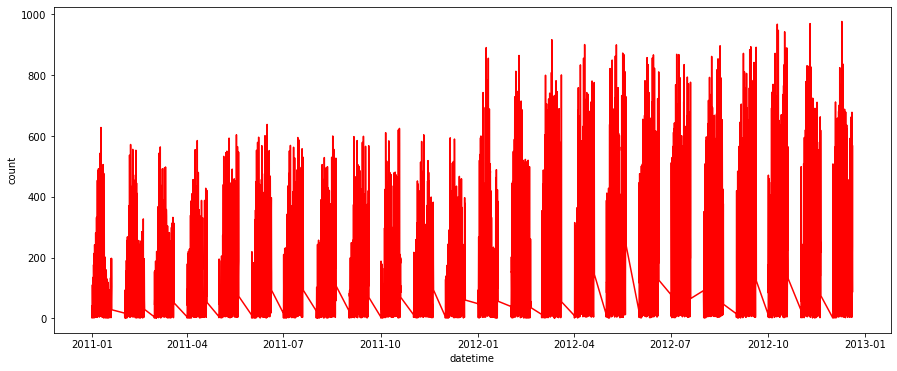

In [8]:
plt.figure(figsize=(15,6))
sns.lineplot("datetime","count", data=train, color="red")
plt.show()

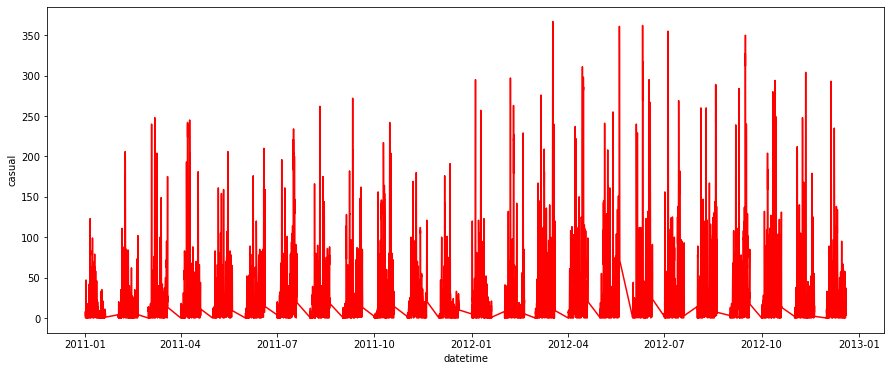

In [9]:
plt.figure(figsize=(15,6))
sns.lineplot("datetime","casual", data=train, color="red")
plt.show()

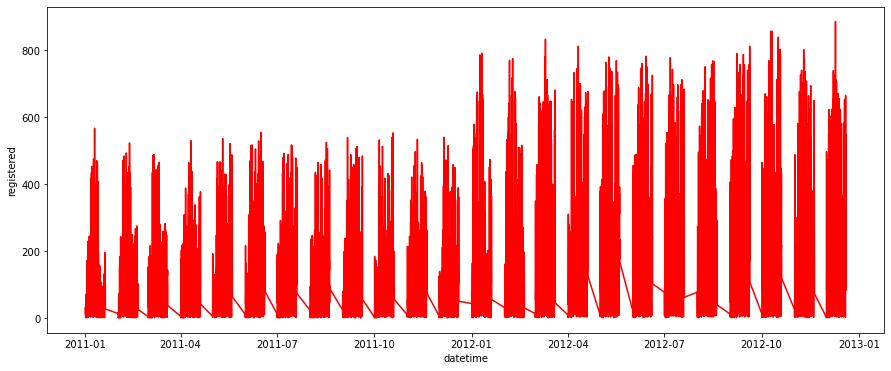

In [10]:
plt.figure(figsize=(15,6))
sns.lineplot("datetime","registered", data=train, color="red")
plt.show()

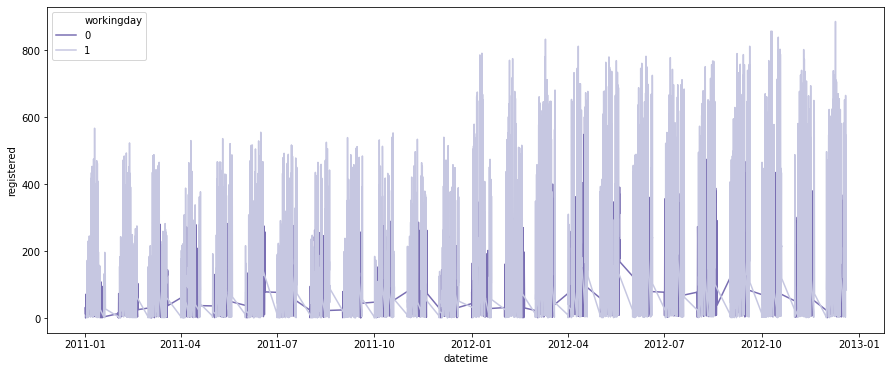

In [11]:
plt.figure(figsize=(15,6))
sns.lineplot("datetime","registered", data=train, hue="workingday", palette="Purples_r")
plt.show()

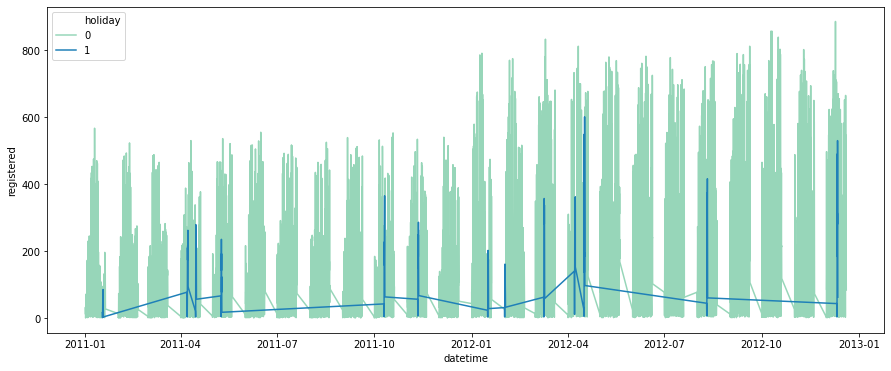

In [12]:
plt.figure(figsize=(15,6))
sns.lineplot("datetime","registered", data=train, hue="holiday", palette="YlGnBu")
plt.show()

In [13]:
train.season = train.season.astype("object")
train.weather = train.weather.astype("object")
# converting the seasons and weather to object from integers

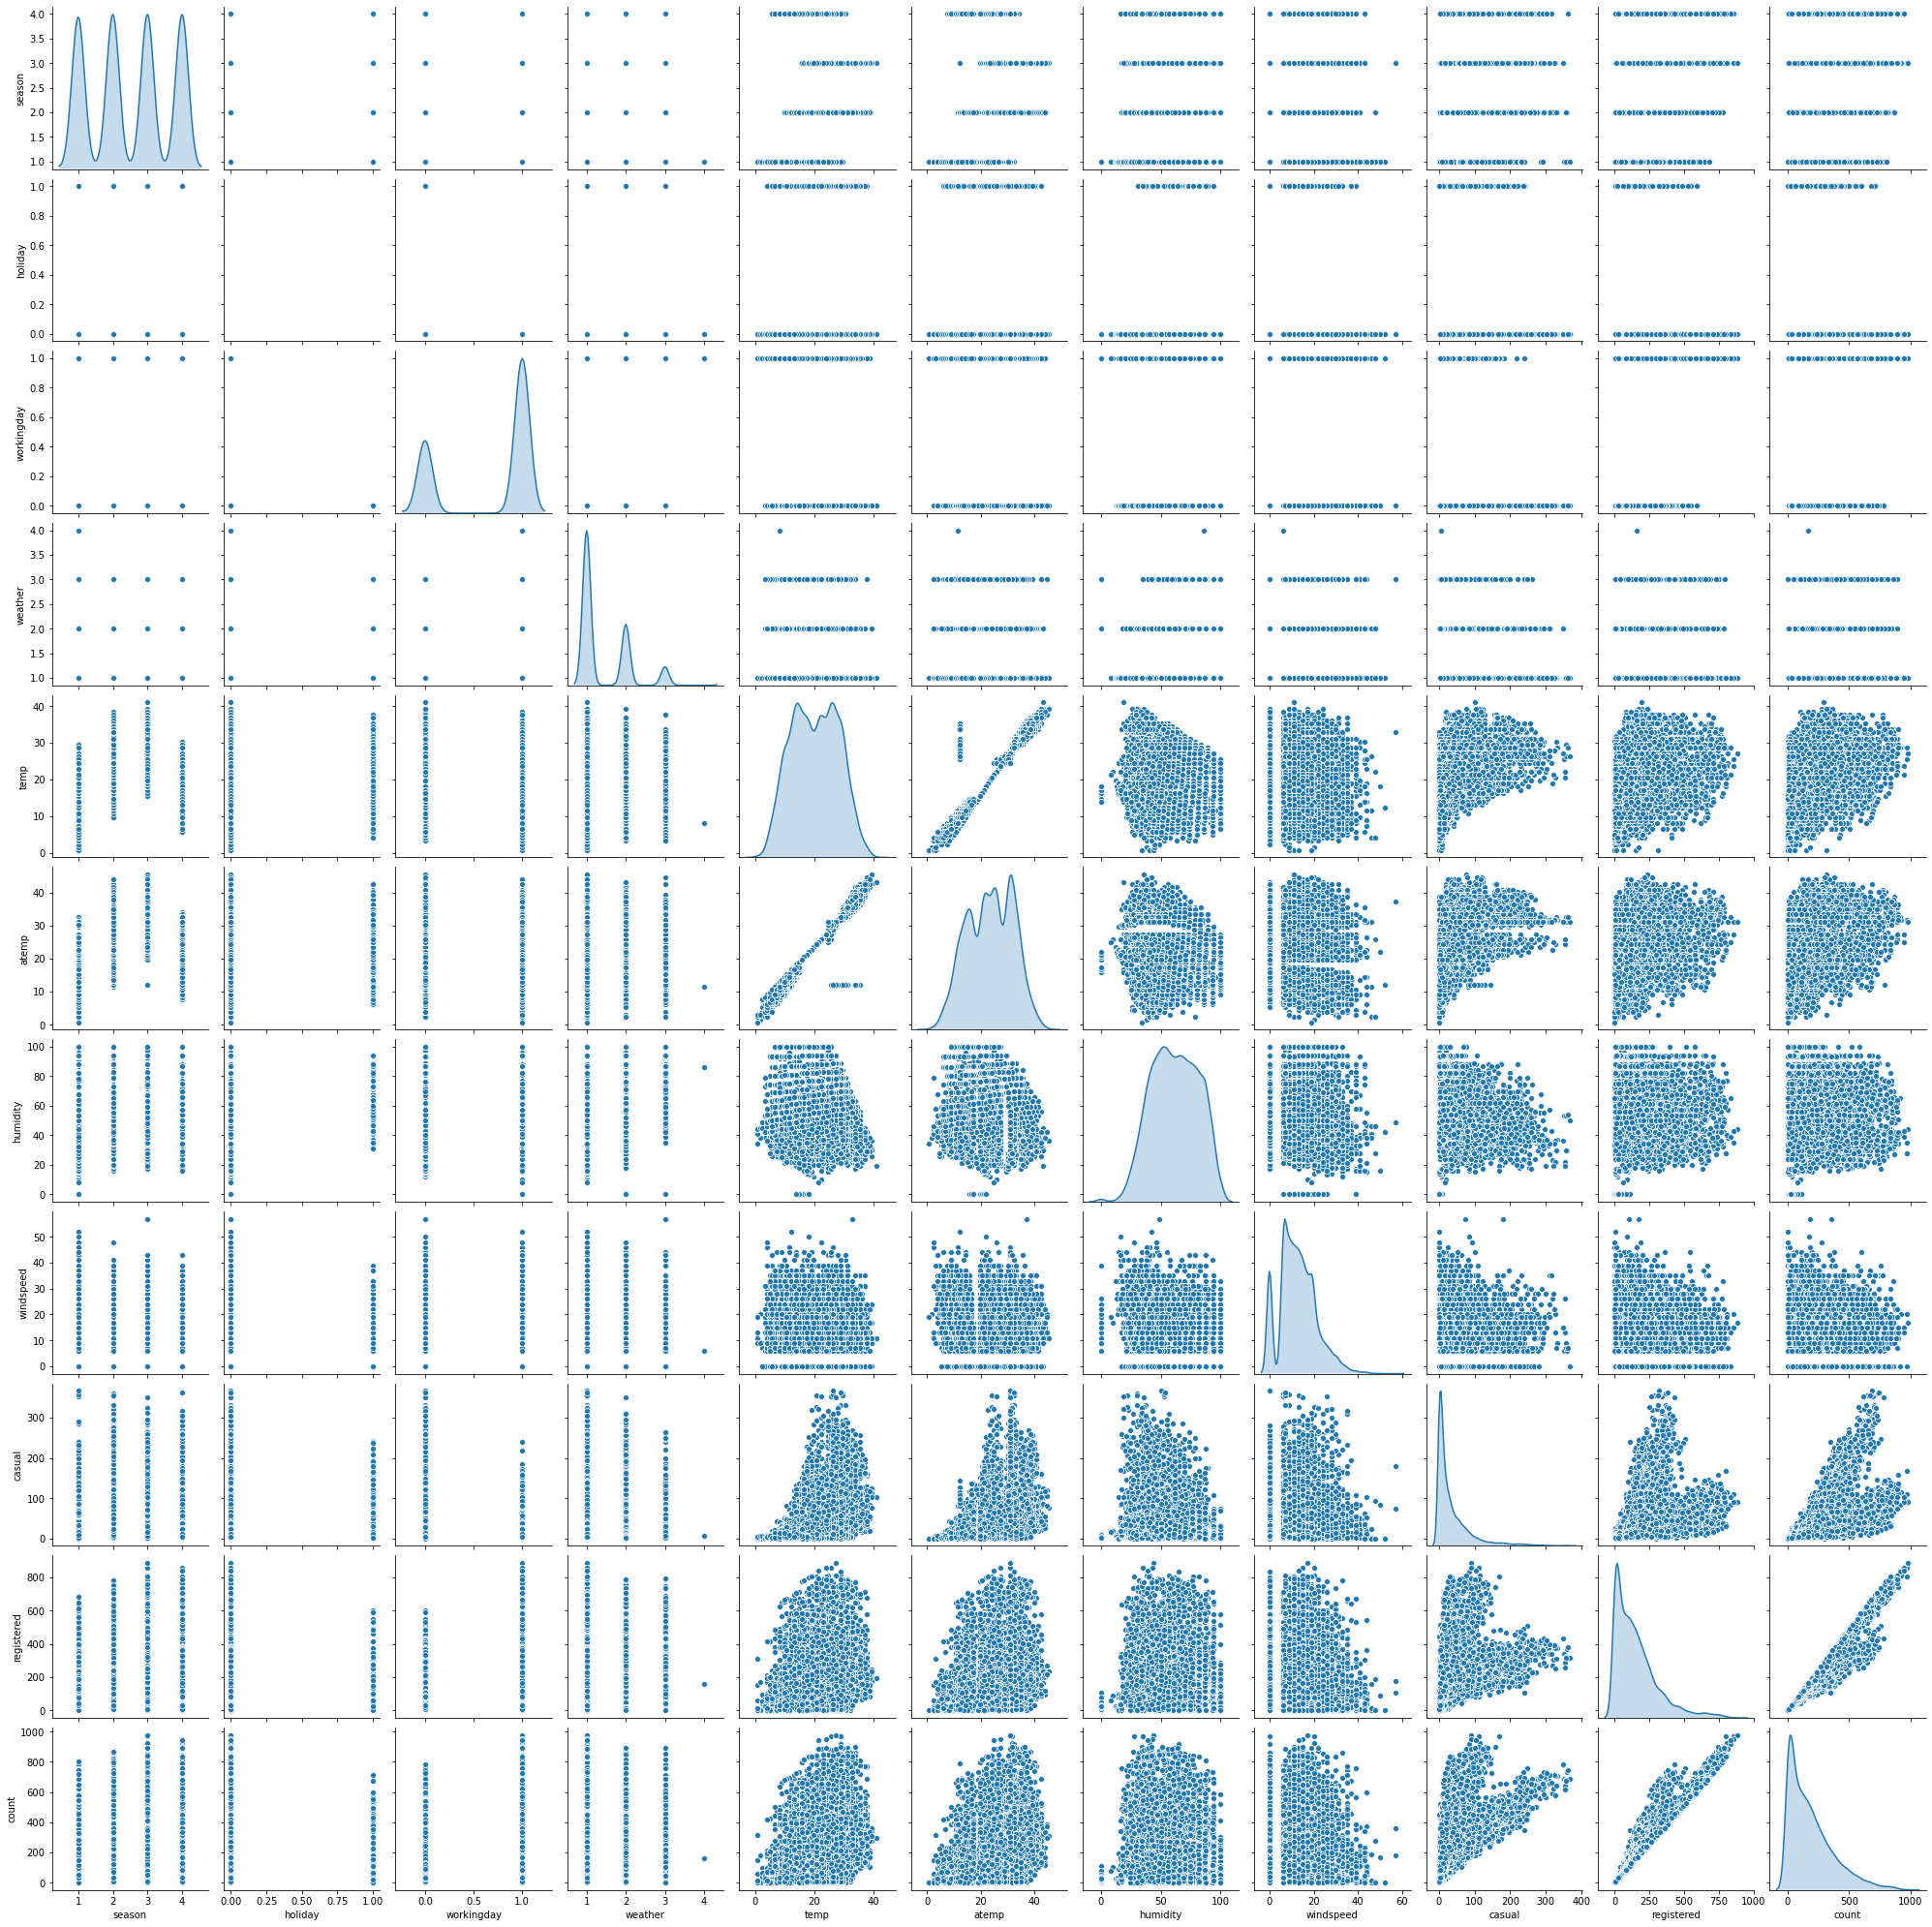

In [14]:
sns.pairplot(train,diag_kind="kde")
plt.show()

* atemp and temp have a linear relationship around them
* count and registered also have a linear relationship
* count and casual also share but not a high linear relationship
* casual and registered have same pattern as count and casual
* season is distributed equally around the 4 types
* holidays are lower than non holidays
* weekdays are the highest
* humidity seems to show a negative relationship with casual
* windspeed seems to have a negative relationship with the count

## FEATURE EXTRACTION

In [15]:
# selecting the year
train['year']=train['datetime'].dt.year
# extracting the month
train['month']=train['datetime'].dt.month
# extracting the day
train['day']=train['datetime'].dt.day
# extracting the dayofweek
train['dayofweek']=train['datetime'].dt.dayofweek
# extracting the hour
train['hour'] = train['datetime'].dt.hour


# selecting the year
test['year']=test['datetime'].dt.year
# extracting the month
test['month']=test['datetime'].dt.month
# extracting the day
test['day']=test['datetime'].dt.day
# extracting the dayofweek
test['dayofweek']=test['datetime'].dt.dayofweek
# extracting the hour
test['hour'] = test['datetime'].dt.hour

In [16]:
df= train.copy().drop('datetime',1)
# creating a copy of the original data to work on

In [17]:
df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,dayofweek,hour
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,5,0
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,5,1
2,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,5,2
3,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,5,3
4,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,5,4


In [18]:
pd.DataFrame({"train":df.nunique(),"test":test.nunique()}).fillna(0).astype(int)
# unique values in training and testing data

,train,test
atemp,60,65
casual,309,0
count,822,0
datetime,0,6493
day,19,12
dayofweek,7,7
holiday,2,2
hour,24,24
humidity,89,79
month,12,12


### Statistical Significance

In [19]:
categorical =["day","year","weather","season","workingday","holiday","dayofweek","month","hour"]
numerical =["casual","registered","humidity","temp","atemp","windspeed","count"]

# dividing the data into numerical and categorical parts

In [20]:
import statsmodels.api as sm

X= df.drop(['casual','registered','count'],1)
y=df['count']

sm.OLS(y, sm.add_constant(pd.get_dummies(X, drop_first=True))).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.396
Model:                            OLS   Adj. R-squared:                  0.395
Method:                 Least Squares   F-statistic:                     419.7
Date:                Thu, 23 Jul 2020   Prob (F-statistic):               0.00
Time:                        19:47:52   Log-Likelihood:                -69299.
No. Observations:               10886   AIC:                         1.386e+05
Df Residuals:                   10868   BIC:                         1.388e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -1.63e+05   5487.277    -29.698      0.000   -1.74e+05   -1.52e+05
holiday       -6.4378      8.524     -0.755      0.450     -23.147      10.272
workingday     2.2350      3.164      0.706      0.480      -3.968       8.437
temp           5.3139      1.105      4.811      0.000       3.149       7.479
atemp          2.7715      0.969      2.861      0.004       0.873       4.670
humidity      -1.8875      0.088    -21.382      0.000      -2.061      -1.714
windspeed      0.5203      0.182      2.853      0.004       0.163       0.878
year          81.0160      2.728     29.700      0.000      75.669      86.363
month          0.6644      0.428      1.553      0.121      -0.174       1.503
day            0.4521      0.273      1.658      0.097      -0.082       0.987
dayofweek      2.1350      0.716      2.984      0.003       0.732       3.538
hour           7.6741      0.209     36.687      0.000       7.264       8.084
season_2      22.1085      5.041      4.386      0.000      12.227      31.990
season_3      -1.2463      6.578     -0.189      0.850     -14.141      11.648
season_4      64.6356      4.736     13.647      0.000      55.352      73.920
weather_2      6.6289      3.295      2.012      0.044       0.171      13.087
weather_3    -29.7525      5.566     -5.345      0.000     -40.664     -18.841
weather_4     47.6803    140.974      0.338      0.735    -228.654     324.015
==============================================================================
Omnibus:                     2126.464   Durbin-Watson:                   0.567
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4104.602
Skew:                           1.194   Prob(JB):                         0.00
Kurtosis:                       4.831   Cond. No.                     8.18e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.18e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### BACKWARD ELIMINATION

In [21]:
df.drop(df[df.weather==4].index,inplace=True)
df.drop('atemp',1,inplace=True)

dummied=pd.get_dummies(df,columns=['weather','season'],dtype='int',drop_first=True)
test_dummied=pd.get_dummies(test,columns=['weather','season'],dtype='int',drop_first=True)

X= dummied.drop(['casual','registered','count'],1)
y=dummied['count']

#Adding constant column of ones, mandatory for sm.OLS model
X_1 = sm.add_constant(pd.get_dummies(X, drop_first=True))
#Fitting sm.OLS model
model = sm.OLS(y,X_1).fit()
#Backward Elimination
cols = list(X.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(selected_features_BE)

['temp', 'humidity', 'windspeed', 'year', 'dayofweek', 'hour', 'weather_2', 'weather_3', 'season_2', 'season_4']


In [22]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

reg_train =dummied[['temp', 'humidity', 'windspeed', 'year', 'dayofweek', 'hour', 'weather_2', 'weather_3', 'season_2', 'season_4']]

vif = [variance_inflation_factor(sm.add_constant(reg_train).values, i) for i in range(sm.add_constant(reg_train).shape[1])]
pd.DataFrame({'vif': vif[1:]}, index=reg_train.columns).T

,temp,humidity,windspeed,year,dayofweek,hour,weather_2,weather_3,season_2,season_4
vif,1.131053,1.50129,1.157169,1.014796,1.005658,1.130758,1.138509,1.22551,1.143715,1.209571


In [23]:
df.corr()

,holiday,workingday,temp,humidity,windspeed,casual,registered,count,year,month,day,dayofweek,hour
holiday,1.000000,-0.250486,0.000270,0.001949,0.008396,0.043790,-0.020955,-0.005395,0.012037,-0.059116,0.022454,-0.079876,-0.000339
workingday,-0.250486,1.000000,0.030067,-0.010960,0.013426,-0.319085,0.119461,0.011604,-0.002545,0.027334,-0.009457,-0.288285,0.002722
temp,0.000270,0.030067,1.000000,-0.064783,-0.017973,0.467071,0.318608,0.394476,0.061377,0.041938,0.151337,-0.039932,0.145584
humidity,0.001949,-0.010960,-0.064783,1.000000,-0.318544,-0.348149,-0.265479,-0.317377,-0.078730,0.036972,0.094381,-0.006293,-0.278150
windspeed,0.008396,0.013426,-0.017973,-0.318544,1.000000,0.092235,0.091056,0.101361,-0.015146,-0.021757,-0.044798,-0.026044,0.146713
casual,0.043790,-0.319085,0.467071,-0.348149,0.092235,1.000000,0.497259,0.690417,0.145305,0.012839,0.064418,0.117493,0.302114
registered,-0.020955,0.119461,0.318608,-0.265479,0.091056,0.497259,1.000000,0.970949,0.264275,0.063207,0.086085,-0.031341,0.380554
count,-0.005395,0.011604,0.394476,-0.317377,0.101361,0.690417,0.970949,1.000000,0.260429,0.056243,0.089544,0.006272,0.400631
year,0.012037,-0.002545,0.061377,-0.078730,-0.015146,0.145305,0.264275,0.260429,1.000000,-0.002019,0.000079,-0.003870,-0.004320
month,-0.059116,0.027334,0.041938,0.036972,-0.021757,0.012839,0.063207,0.056243,-0.002019,1.000000,0.004788,-0.000821,-0.001879


* Since the correlation is low, the linear regression will not work

### Linear Regression

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

logreg = LinearRegression()
X= reg_train.copy()
y=df['count']

logreg.fit(X,y)
print(logreg.score(X,y))

predictions = abs(logreg.predict(X))
print(metrics.mean_squared_log_error(y, predictions))

0.3955129627055757
1.4822390558486052


### Decision tree Classifier

In [25]:
X = train.copy()

X[['holiday', 'season', 'workingday', 'weather', 'month', 'hour', 'year', 'day']]=X[['holiday', 'season', 'workingday', 'weather', 'month', 'hour', 'year', 'day']] .astype("object")

testing = test.copy()
testing[['holiday', 'season', 'workingday', 'weather', 'month', 'hour', 'year', 'day']]=testing[['holiday', 'season', 'workingday', 'weather', 'month', 'hour', 'year', 'day']] .astype("object")

X.drop(['datetime','dayofweek','atemp','casual','registered','count'],1, inplace=True)

y=train['count']

In [26]:
from sklearn.tree import DecisionTreeRegressor
dtc=DecisionTreeRegressor()
dtc.fit(X,y)
dtc.score(X,y)

1.0

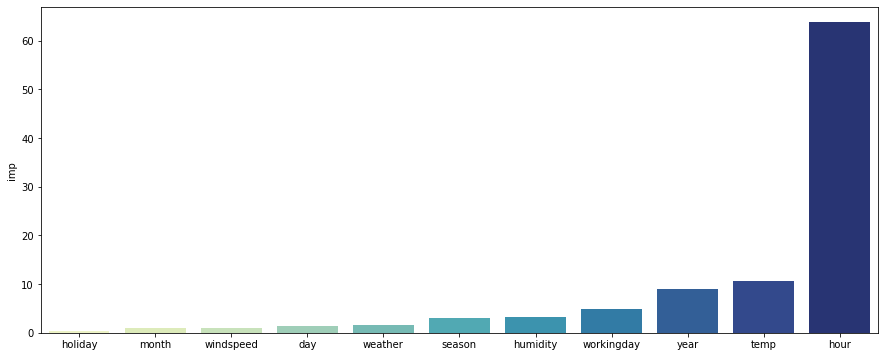

In [27]:
featimp=pd.DataFrame(dtc.feature_importances_*100, index= X.columns, columns=["imp"]).sort_values("imp")
plt.figure(figsize=(15,6))
sns.barplot(x=featimp.index, y =featimp['imp'], palette="YlGnBu")
plt.show()

### Bagging

In [29]:
from sklearn.ensemble import BaggingRegressor
rmsle=[]
for i in np.arange(1,500,10):
    casual = train.casual
    registered=train.registered

    casual_gb=BaggingRegressor(n_estimators=i,random_state=45,bootstrap_features=True, oob_score=True, n_jobs=-1)
    reg_gb=BaggingRegressor(n_estimators=i,random_state=45,bootstrap_features=True, oob_score=True, n_jobs=-1)

    casual_gb.fit(X,casual)
    casual_gb.score(X,casual)
    cas_pred = casual_gb.predict(X)


    reg_gb.fit(X,registered)
    reg_gb.score(X,registered)
    reg_pred = reg_gb.predict(X)


    pred= cas_pred+reg_pred
    rmsle.append(np.sqrt(metrics.mean_squared_log_error(pred, train['count'])))
    

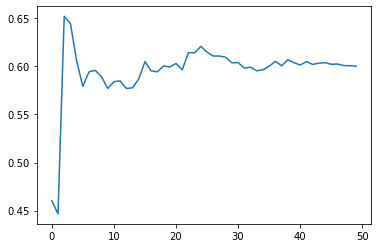

In [30]:
plt.plot(rmsle)

In [31]:
np.argmin(rmsle)

1

In [32]:
casual = train.casual
registered=train.registered

casual_bg=BaggingRegressor(n_estimators=2,random_state=45,bootstrap_features=True, oob_score=True, n_jobs=-1)
reg_bg=BaggingRegressor(n_estimators=2,random_state=45,bootstrap_features=True, oob_score=True, n_jobs=-1)

casual_bg.fit(X,casual)
casual_bg.score(X,casual)
cas_pred = casual_bg.predict(X)
print(casual_bg.oob_score_)

reg_bg.fit(X,registered)
reg_bg.score(X,registered)
reg_pred = reg_bg.predict(X)
print(reg_bg.oob_score_)

pred= cas_pred+reg_pred
np.sqrt(metrics.mean_squared_log_error(pred, train['count']))

0.023965683145988348
-0.3296785991825548


0.6793400467853559

### Random forest -FINAL MODEL

In [33]:
from sklearn.ensemble import RandomForestRegressor
rmsle=[]
for i in np.arange(1,500,10):
    casual = train.casual
    registered=train.registered

    casual_rf=RandomForestRegressor(n_estimators=i, oob_score=True, n_jobs=-1,min_samples_split=5, random_state=45)
    reg_rf=RandomForestRegressor(n_estimators=i, oob_score=True, n_jobs=-1,min_samples_split=5,random_state=45)

    casual_rf.fit(X,casual)
    casual_rf.score(X,casual)
    cas_pred = casual_rf.predict(X)


    reg_rf.fit(X,registered)
    reg_rf.score(X,registered)
    reg_pred = reg_rf.predict(X)


    pred= cas_pred+reg_pred
    rmsle.append(np.sqrt(metrics.mean_squared_log_error(pred, train['count'])))

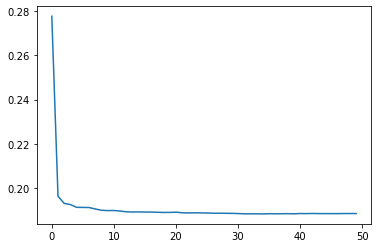

In [34]:
plt.plot(rmsle)

In [35]:
casual = train.casual
registered=train.registered

casual_rf=RandomForestRegressor(oob_score=True,n_jobs=-1,min_samples_split=5, random_state=45)
reg_rf=RandomForestRegressor(oob_score=True, n_jobs=-1,min_samples_split=5,random_state=45)

casual_rf.fit(X,casual)
casual_rf.score(X,casual)
cas_pred = casual_rf.predict(X)
print(casual_rf.oob_score_)

reg_rf.fit(X,registered)
reg_rf.score(X,registered)
reg_pred = reg_rf.predict(X)
print(reg_rf.oob_score_)

pred= cas_pred+reg_pred
np.sqrt(metrics.mean_squared_log_error(pred, train['count']))

0.9196293896103507
0.9431728093006847


0.18972249136908248

### Predicting the test data

In [36]:
cas_test = casual_rf.predict(test[X.columns])
reg_test = reg_rf.predict(test[X.columns])

count_test = cas_test+reg_test

submission=pd.DataFrame({"datetime":test.datetime, "count":count_test})
submission.to_csv("samplesubmission.csv", index=False)